# Bitcoin Price Prediction

In [1]:
%matplotlib inline

In [2]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [3]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### Loading data

In [8]:
market = 'bitcoin'

In [9]:
market_data = pd.read_html('https://coinmarketcap.com/currencies/' + 'bitcoin' +
                             '/historical-data/?start=20130428&end='+
                           time.strftime('%Y%m%d'), flavor='html5lib')[0]

In [12]:
market_data.shape

(1845, 7)

### Write data to csv

In [5]:
bitcoin = pd.read_csv('bitcoin.csv')

In [8]:
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])

In [10]:
bitcoin.dtypes

Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume                object
Market Cap             int64
dtype: object

In [11]:
bitcoin.head(3)

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-05-16,8504.41,8508.43,8175.49,8368.83,6760220000,144878000000
1,2018-05-15,8705.19,8836.19,8456.45,8510.38,6705710000,148283000000
2,2018-05-14,8713.10,8881.12,8367.97,8716.79,7364150000,148403000000


In [17]:
bitcoin['Volume'] = (pd.to_numeric(bitcoin['Volume'], errors='coerce').fillna(0))

In [18]:
bitcoin['Volume'].describe()

count    1.845000e+03
mean     1.126643e+09
std      3.010131e+09
min      0.000000e+00
25%      1.713010e+07
50%      4.742440e+07
75%      2.093120e+08
max      2.384090e+10
Name: Volume, dtype: float64

### There are 0 values in volume, check why

In [20]:
bitcoin[bitcoin['Volume'] == 0].head()

,Date,Open,High,Low,Close,Volume,Market Cap
1602,2013-12-26,683.94,777.75,683.94,761.98,0.0,8326270000
1603,2013-12-25,666.31,682.70,649.48,682.21,0.0,8108930000
1604,2013-12-24,672.36,684.39,645.71,665.58,0.0,8179730000
1605,2013-12-23,613.06,680.91,611.04,673.41,0.0,7455670000
1606,2013-12-22,601.78,666.74,585.64,617.18,0.0,7315940000


### Delete data before 12-26

In [21]:
bitcoin = bitcoin[bitcoin['Date'] > '2013-12-27']
bitcoin.shape

(1601, 7)

In [22]:
bitcoin.to_csv('bitcoin.csv', index=False)

In [4]:
bitcoin = pd.read_csv('bitcoin.csv')

In [5]:
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])

In [6]:
bitcoin.head(3)

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-05-16,8504.41,8508.43,8175.49,8368.83,6.760220e+09,144878000000
1,2018-05-15,8705.19,8836.19,8456.45,8510.38,6.705710e+09,148283000000
2,2018-05-14,8713.10,8881.12,8367.97,8716.79,7.364150e+09,148403000000


### Modelling

#### Steps:
    1. Remove redundant columns and sort data by Date in ascending order
    2. Normalize data into [0, 1]
    3. Split data into train and test set
    4. Set time window and reshape data set
    5. LSTM model
    6. Predict

#### Remove redundant columns and sort date

In [7]:
# input data: data frame
def create_train_data(data):
    data = data.sort_values(by='Date')
    data.drop(['Market Cap'], axis=1, inplace=True)
    return data

In [8]:
bitcoin = create_train_data(bitcoin)
bitcoin.head(3)

,Date,Open,High,Low,Close,Volume
1600,2013-12-28,737.98,747.06,705.35,727.83,32505800.0
1599,2013-12-29,728.05,748.61,714.44,745.05,19011300.0
1598,2013-12-30,741.35,766.60,740.24,756.13,20707700.0


#### Normalization
Normalize all columns into range 0 to 1. (The normalization is based on the whole interval
which raises the question if the model can predict value over 1) An alternative is normalize
the data based on the first value in the window.

In [9]:
# input data: data frame
# output is an array with Date removed and data normalized
scaler = MinMaxScaler(feature_range=(0, 1))
def norm_data(data):
    norm_data = data.drop('Date', axis=1, inplace=False)
    norm_data = scaler.fit_transform(norm_data.values)
    return norm_data

In [10]:
bitcoin_norm = norm_data(bitcoin)
print bitcoin_norm.shape

(1601, 5)


#### Split data

In [11]:
# input data is the whole data set of array type
# output is train and test set with Close value included
def split_data(data, train_size=.7):
    ind = int(len(data)*train_size)
    train = data[:ind]
    test = data[ind:]
    return train, test

In [12]:
train, test = split_data(bitcoin_norm)
print 'train size is:', train.shape, '| test size is:', test.shape

train size is: (1120, 5) | test size is: (481, 5)


#### Set time window get data set suit for model

In [13]:
# input data is an array
# output is prepared data array set with dimension (sample_size, time_step, num_features)
def shape_data(data, window_len=None):
    # index 3 is Close which is the response variable
    X = data[:, [0, 1, 2, 4]]
    y = data[:, 3]
    data_X, data_y = [], []
    data_len = len(data)
    for i in range(data_len-window_len):
        data_X.append(X[i:(i+window_len)])
        data_y.append(y[i+window_len])
    assert len(data_X) == len(data_y)
    print 'sample size is', len(data_X)
    return np.array(data_X), np.array(data_y)

In [14]:
# Here window size set to 10
window_len = 10

In [15]:
train_X, train_y = shape_data(train, window_len)
test_X, test_y = shape_data(test, window_len)

sample size is 1110
sample size is 471


In [16]:
print train_X.shape

(1110, 10, 4)


In [17]:
print test_X.shape

(471, 10, 4)


### Built LSTM

In [20]:
# Set default number of neurons 50, 
# activation function sigmoid and dropout rate 0.2, metric mae
def built_model(num_units=50, activation='sigmoid', drop_rate=.2, measure='mae'):
    model = Sequential()
    model.add(LSTM(units=num_units, activation=activation, 
                   input_shape=(train_X.shape[1], train_X.shape[2])))
    # model.add(Dropout(drop_rate))
    model.add(Dense(1))
    model.compile(loss=measure, optimizer='adam')
    
    print model.summary()
    return model

In [21]:
model = built_model(num_units=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
# Here set shuffle equals true while most prediction set shuffle as false (ignore)
# Epochs set 100
start = time.time()
history = model.fit(train_X, train_y, epochs=100, 
                    batch_size=16, validation_data=(test_X, test_y), verbose=0, shuffle=False)
print 'running time', time.time()-start

running time 77.0970051289


In [24]:
gc.collect()

550

#### Result visualisation

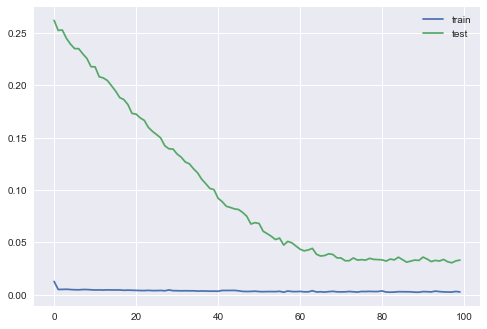

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

#### The error is weired !!

### Predict

In [25]:
pred_y = model.predict(test_X)

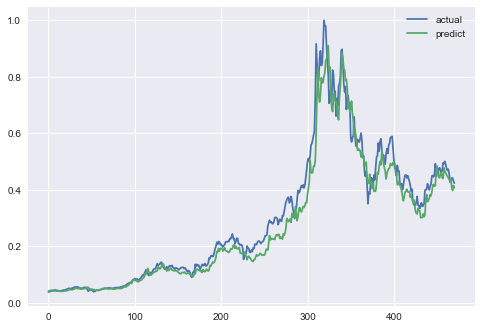

In [26]:
plt.plot(test_y, label='actual')
plt.plot(pred_y, label='predict')
plt.legend()

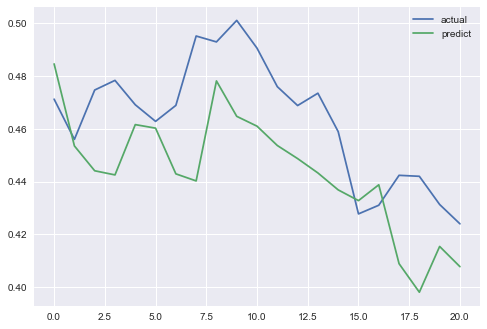

In [27]:
# zoom in
plt.plot(test_y[450:], label='actual')
plt.plot(pred_y[450:], label='predict')
plt.legend()

#### Conclusion:
The prediction turns out to be very different from my reference.  The good side is that 
the model is not just learning from the previous price, while actually most prediction only learns the price of the previous day, which is meaningless
in actual prediction.  The down side is that the prediction error is large and some 
predictions can be opposite.

#### Reference:
    [1] https://towardsdatascience.com/bitcoin-price-prediction-using-lstm-9eb0938c22bd
    [2] https://www.kaggle.com/jphoon/bitcoin-time-series-prediction-with-lstm/code
    [3] https://medium.com/@siavash_37715/how-to-predict-bitcoin-and-ethereum-price-with-rnn-lstm-in-keras-a6d8ee8a5109

#### Try 30 days time window

In [28]:
window_len = 30

In [29]:
train_X, train_y = shape_data(train, window_len)
test_X, test_y = shape_data(test, window_len)

sample size is 1090
sample size is 451


In [31]:
model = built_model(num_units=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
start = time.time()
history = model.fit(train_X, train_y, epochs=100, 
                    batch_size=16, validation_data=(test_X, test_y), verbose=0, shuffle=False)
print 'running time', time.time()-start

running time 180.856420994


In [35]:
pred_y = model.predict(test_X)

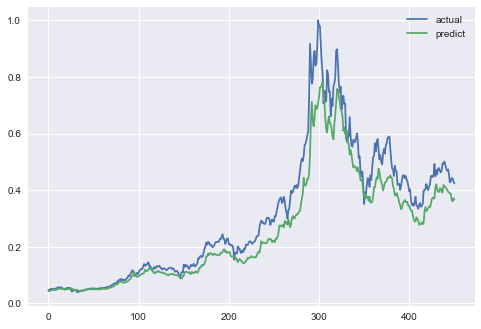

In [36]:
plt.plot(test_y, label='actual')
plt.plot(pred_y, label='predict')
plt.legend()

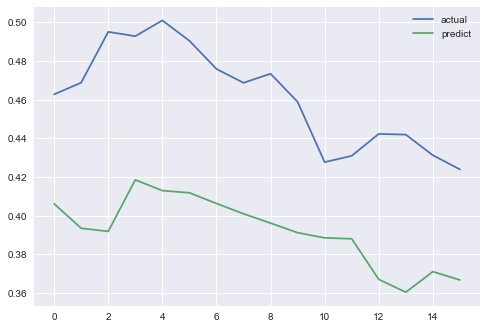

In [39]:
plt.plot(test_y[435:], label='actual')
plt.plot(pred_y[435:], label='predict')
plt.legend()

#### Not help